In [1]:
# Import các thư viện
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import numpy as np
import os
import glob
from ast import literal_eval
import itertools

import warnings
warnings.simplefilter('ignore')

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from textblob import Word
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix,f1_score,roc_auc_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Đọc danh sách stopwords bổ sung từ file CSV
stopwords_lstm = pd.read_csv('../Train_LSTM/stopwords_lstm.csv')

# Định nghĩa hàm tiền xử lý văn bản
def preprocess(text):
    # Khởi tạo danh sách stopwords mặc định
    stopwords = set(STOPWORDS)

    # Bổ sung các stopwords liên quan đến hàng không từ file
    stopwords.update([str(i).lower() for i in stopwords_lstm.name])

    # Định nghĩa các bộ lọc tìm kiếm
    mentions_filter = re.compile(r'(?<=\@)(\w+)')  # Tìm @mention
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')  # Tìm hashtag
    flight_numbers = re.compile(r'(flt\d*)')  # Tìm mã chuyến bay (flt123, ...)

    # Tìm các từ tương ứng với regex
    all_mentions = mentions_filter.findall(text.lower())  # Danh sách mentions
    all_hashtag = hashtags_filter.findall(text.lower())  # Danh sách hashtags
    all_flights = flight_numbers.findall(text.lower())  # Danh sách mã chuyến bay

    word_lemmatize = WordNetLemmatizer()  # Khởi tạo lemmatizer để chuẩn hóa từ

    # Hàm xử lý từ bằng lemmatization
    def stem_tokens(tokens, lemmatize):
        lemmatized = []  # Danh sách lưu từ đã xử lý
        for item in tokens:
            lemmatized.append(word_lemmatize.lemmatize(item, 'v'))  # Lemmatize dạng động từ
        return lemmatized

    # Hàm xóa emoji khỏi văn bản
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')  # Bỏ emoji bằng cách giữ ký tự ASCII

    # Loại bỏ emoji khỏi văn bản
    text = deEmojify(text)

    # Loại bỏ HTML tags
    soup = BeautifulSoup(text)
    text = soup.get_text()

    # Loại bỏ dấu câu
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)

    # Tách từ trong văn bản
    word_tokens = nltk.word_tokenize(text)

    # Chỉ giữ các từ có độ dài từ 2 đến 15
    filtered_tokens = [x for x in word_tokens if len(x) > 2 and len(x) < 15]

    # Lemmatize và loại bỏ stopwords
    tokens = stem_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions)
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]

    return all_tokens  # Trả về danh sách từ đã xử lý

In [3]:
# Tải mô hình học sâu được huấn luyện trước
model = load_model("../Train_LSTM/model_new.h5")  # Tải cấu trúc mô hình
model.load_weights('../Train_LSTM/model_weights_new.weights.h5')  # Tải trọng số đã huấn luyện
model.compile(loss='categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])  # Biên dịch mô hình

# Đọc độ dài chuỗi tối đa từ file
f = open('../Train_LSTM/X_train_max_length_new.txt', "r")
max_length = int(f.read())

# Đọc dữ liệu huấn luyện và xử lý
df_vals = pd.read_csv('../Train_LSTM/train_text_vals_new.csv', converters={'text_tokenized': literal_eval})
tokenizer = Tokenizer(num_words=500, split=' ')  # Khởi tạo tokenizer với số từ tối đa là 500
tokenizer.fit_on_texts(df_vals['text_tokenized'].values)  # Huấn luyện tokenizer trên dữ liệu

In [4]:
from sklearn.utils import shuffle
import pandas as pd
# Đọc dữ liệu đầu vào
train_df1 = pd.read_csv("../Data/train_data.csv", encoding="ISO-8859-1")
print(train_df1.columns)  # Kiểm tra cột dữ liệu

# Xóa cột không cần thiết
if 'Unnamed: 0' in train_df1.columns:
    train_df1 = train_df1.drop(['Unnamed: 0'], axis=1)

# Loại bỏ các dòng có giá trị null ở cột 'text'
train_df1 = train_df1.dropna(subset=['text'])

# Xáo trộn dữ liệu
from sklearn.utils import shuffle
train_df1 = shuffle(train_df1)
train_df1.head()

Index(['tweet_id', 'username', 'text', 'airline_name', 'tweet_location',
       'airline_sentiment'],
      dtype='object')


,tweet_id,username,text,airline_name,tweet_location,airline_sentiment
28360,5.696190e+17,MarkPerlowitz,@AmericanAir I need to order a special meal an...,American,NaN,Negative
28577,5.702479e+17,DarknesProdigy,@AmericanAir fly my child,American,"Pirate Isle, Arcadia",Neutral
20248,1.711184e+08,barrysherwin61,we are due to fly to las vegas from heathrow t...,British_Airways,"Birmingham, England",Positive
28752,5.702966e+17,nydia376,"@united yes, David Allan send an email with th...",United,USA,Neutral
10195,3.581165e+09,ManishMore259,bring indigo airlines at jharsuguda .spicejet ...,IndiGo6E,NaN,Negative


In [5]:
# Tiền xử lý cột 'text'
train_df1['processed_tweet'] = train_df1['text'].apply(lambda x: preprocess(x))

In [6]:
# Loại bỏ dòng nếu cột 'processed_tweet' rỗng
def remove_if_empty(df):
    empty_ids = df['processed_tweet'].map(lambda i: len(i)) > 0  # Xác định dòng không rỗng
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])  # Xóa dòng rỗng
    return df

In [7]:
# Reset chỉ mục DataFrame
df = train_df1.reset_index(drop=True)

In [8]:
# Loại bỏ dòng rỗng
df = remove_if_empty(df)

In [9]:
df.head()

,tweet_id,username,text,airline_name,tweet_location,airline_sentiment,processed_tweet
0,5.696190e+17,MarkPerlowitz,@AmericanAir I need to order a special meal an...,American,NaN,Negative,"[need, order, special, meal, cant, reach, hold..."
1,5.702479e+17,DarknesProdigy,@AmericanAir fly my child,American,"Pirate Isle, Arcadia",Neutral,"[fly, child]"
2,1.711184e+08,barrysherwin61,we are due to fly to las vegas from heathrow t...,British_Airways,"Birmingham, England",Positive,"[due, fly, las, vegas, heathrow, today, receiv..."
3,5.702966e+17,nydia376,"@united yes, David Allan send an email with th...",United,USA,Neutral,"[unite, yes, allan, send, email, number, case8..."
4,3.581165e+09,ManishMore259,bring indigo airlines at jharsuguda .spicejet ...,IndiGo6E,NaN,Negative,"[bring, indigo, airlines, jharsuguda, spicejet..."


In [10]:
# Chia dữ liệu thành X và y
X = df.drop(['airline_sentiment'], axis=1)  # Đặc trưng đầu vào
y = df['airline_sentiment']  # Nhãn đầu ra

# Chia tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Hàm giải mã kết quả dự đoán
def decode_prediction(prediction):
    if prediction == 0:
        return "Negative"
    elif prediction == 1:
        return "Neutral"
    else:
        return "Positive"

# Hàm dự đoán cảm xúc
def predict_sentiment(text):
    text = preprocess(text)  # Tiền xử lý văn bản
    text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length, dtype='float64')  # Đệm chuỗi
    prediction = model.predict([text])  # Dự đoán cảm xúc
    result = np.where(prediction[0] == np.amax(prediction[0]))  # Lấy nhãn dự đoán mạnh nhất
    return decode_prediction(result[0])  # Trả về nhãn dự đoán

In [12]:
# Dự đoán cảm xúc trên tập kiểm tra
y_pred = X_test['text'].apply(lambda x: predict_sentiment(x))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

In [13]:
# Chuyển đổi nhãn văn bản thành số để so sánh
y_pred = y_pred.map({'Negative':0,'Neutral':1,'Positive':2})
y_test = y_test.map({'Negative':0,'Neutral':1,'Positive':2})

In [14]:
# Tính ma trận nhầm lẫn
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[2389,  302,  554],
       [ 394,  713,  240],
       [ 308,  126,  903]], dtype=int64)

In [15]:
# Vẽ biểu đồ ma trận nhầm lẫn
def plot_confusion_matrix(cm, classes):

    tick_marks = np.arange(len(classes))

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > (cm.max() / 2.0) else "black")

    plt.imshow(cm, cmap = plt.cm.YlGnBu)
    plt.colorbar()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

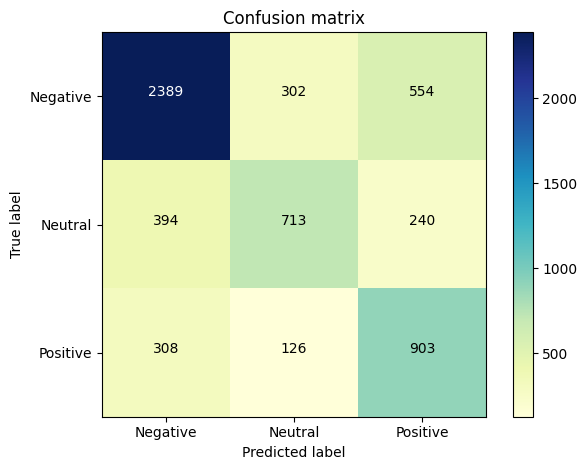

In [16]:
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'])

In [17]:
# In các chỉ số đánh giá
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.68

Weighted Precision: 0.68
Weighted Recall: 0.68
Weighted F1-score: 0.68
